<a href="https://colab.research.google.com/github/neabparinya11/ProjectDeep/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download puneet6060/intel-image-classification

 99% 344M/346M [00:16<00:00, 23.5MB/s]
100% 346M/346M [00:16<00:00, 22.6MB/s]


In [ ]:
! unzip intel-image-classification.zip

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7

In [ ]:
import torchvision
import numpy as np
import os
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,random_split
from torchvision import datasets, models
import matplotlib.pyplot as plt
import cv2
import glob as gb
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from sklearn.utils import shuffle

In [ ]:
Train_path = '/content/seg_train/'
Predict_path = '/content/seg_pred'
Test_path = '/content/seg_test/'

In [ ]:
control_size = 224

train_trans = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((control_size,control_size)),
    torchvision.transforms.Normalize(mean=(0.4302,0.4575,0.4539),std=(0.2362,0.2347,0.2433))
])

test_trans = torchvision.transforms.Compose([
    torchvision.transforms.Resize((control_size,control_size)),
    torchvision.transforms.CenterCrop(control_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.4302,0.4575,0.4539),std=(0.2362,0.2347,0.2433))
])

## **Prepare Data**

In [ ]:
training_data = datasets.ImageFolder(root = Train_path + 'seg_train', transform=train_trans)
test_data = datasets.ImageFolder(root = Test_path + 'seg_test', transform=test_trans)
predict_data = datasets.ImageFolder(root=Predict_path,transform=train_trans)

print(len(training_data))
#dataset_train,dataset_valid = random_split(training_data,[10000,4034])
print(len(test_data))
print(len(predict_data))

14034
3000
7301


In [ ]:
batch_sizes = 64

DataLoad_training = DataLoader(training_data,batch_size=batch_sizes,shuffle=True)
DataLoad_test = DataLoader(test_data,batch_size=batch_sizes )
DataLoad_predict = DataLoader(predict_data,batch_size=batch_sizes)

#dl_train = DataLoader(dataset_train,batch_size=batch_sizes,shuffle=True)
#dl_valid = DataLoader(dataset_valid,batch_size=batch_sizes)

## **Show some sample**

In [ ]:
def show_img(dataset):
  if dataset == training_data or dataset == test_data:
    loader = DataLoad_training
  else:
    loader = DataLoad_test
  
  batch = next(iter(loader))
  images, labels = batch

  grid = torchvision.utils.make_grid(images,nrow = 6)
  plt.figure(figsize=(160,160))
  plt.imshow(np.transpose(grid,(1,2,0)))
  print(f'Labesl : {labels}')


Labesl : tensor([3, 4, 2, 5, 4, 3, 0, 5, 4, 0, 0, 2, 3, 0, 5, 0, 5, 1, 1, 2, 1, 4, 2, 1,
        3, 3, 3, 4, 1, 3, 4, 0, 1, 1, 2, 2, 3, 4, 0, 1, 5, 5, 4, 2, 5, 0, 0, 2,
        2, 1, 2, 5, 5, 3, 3, 1, 2, 2, 1, 5, 0, 3, 2, 2])


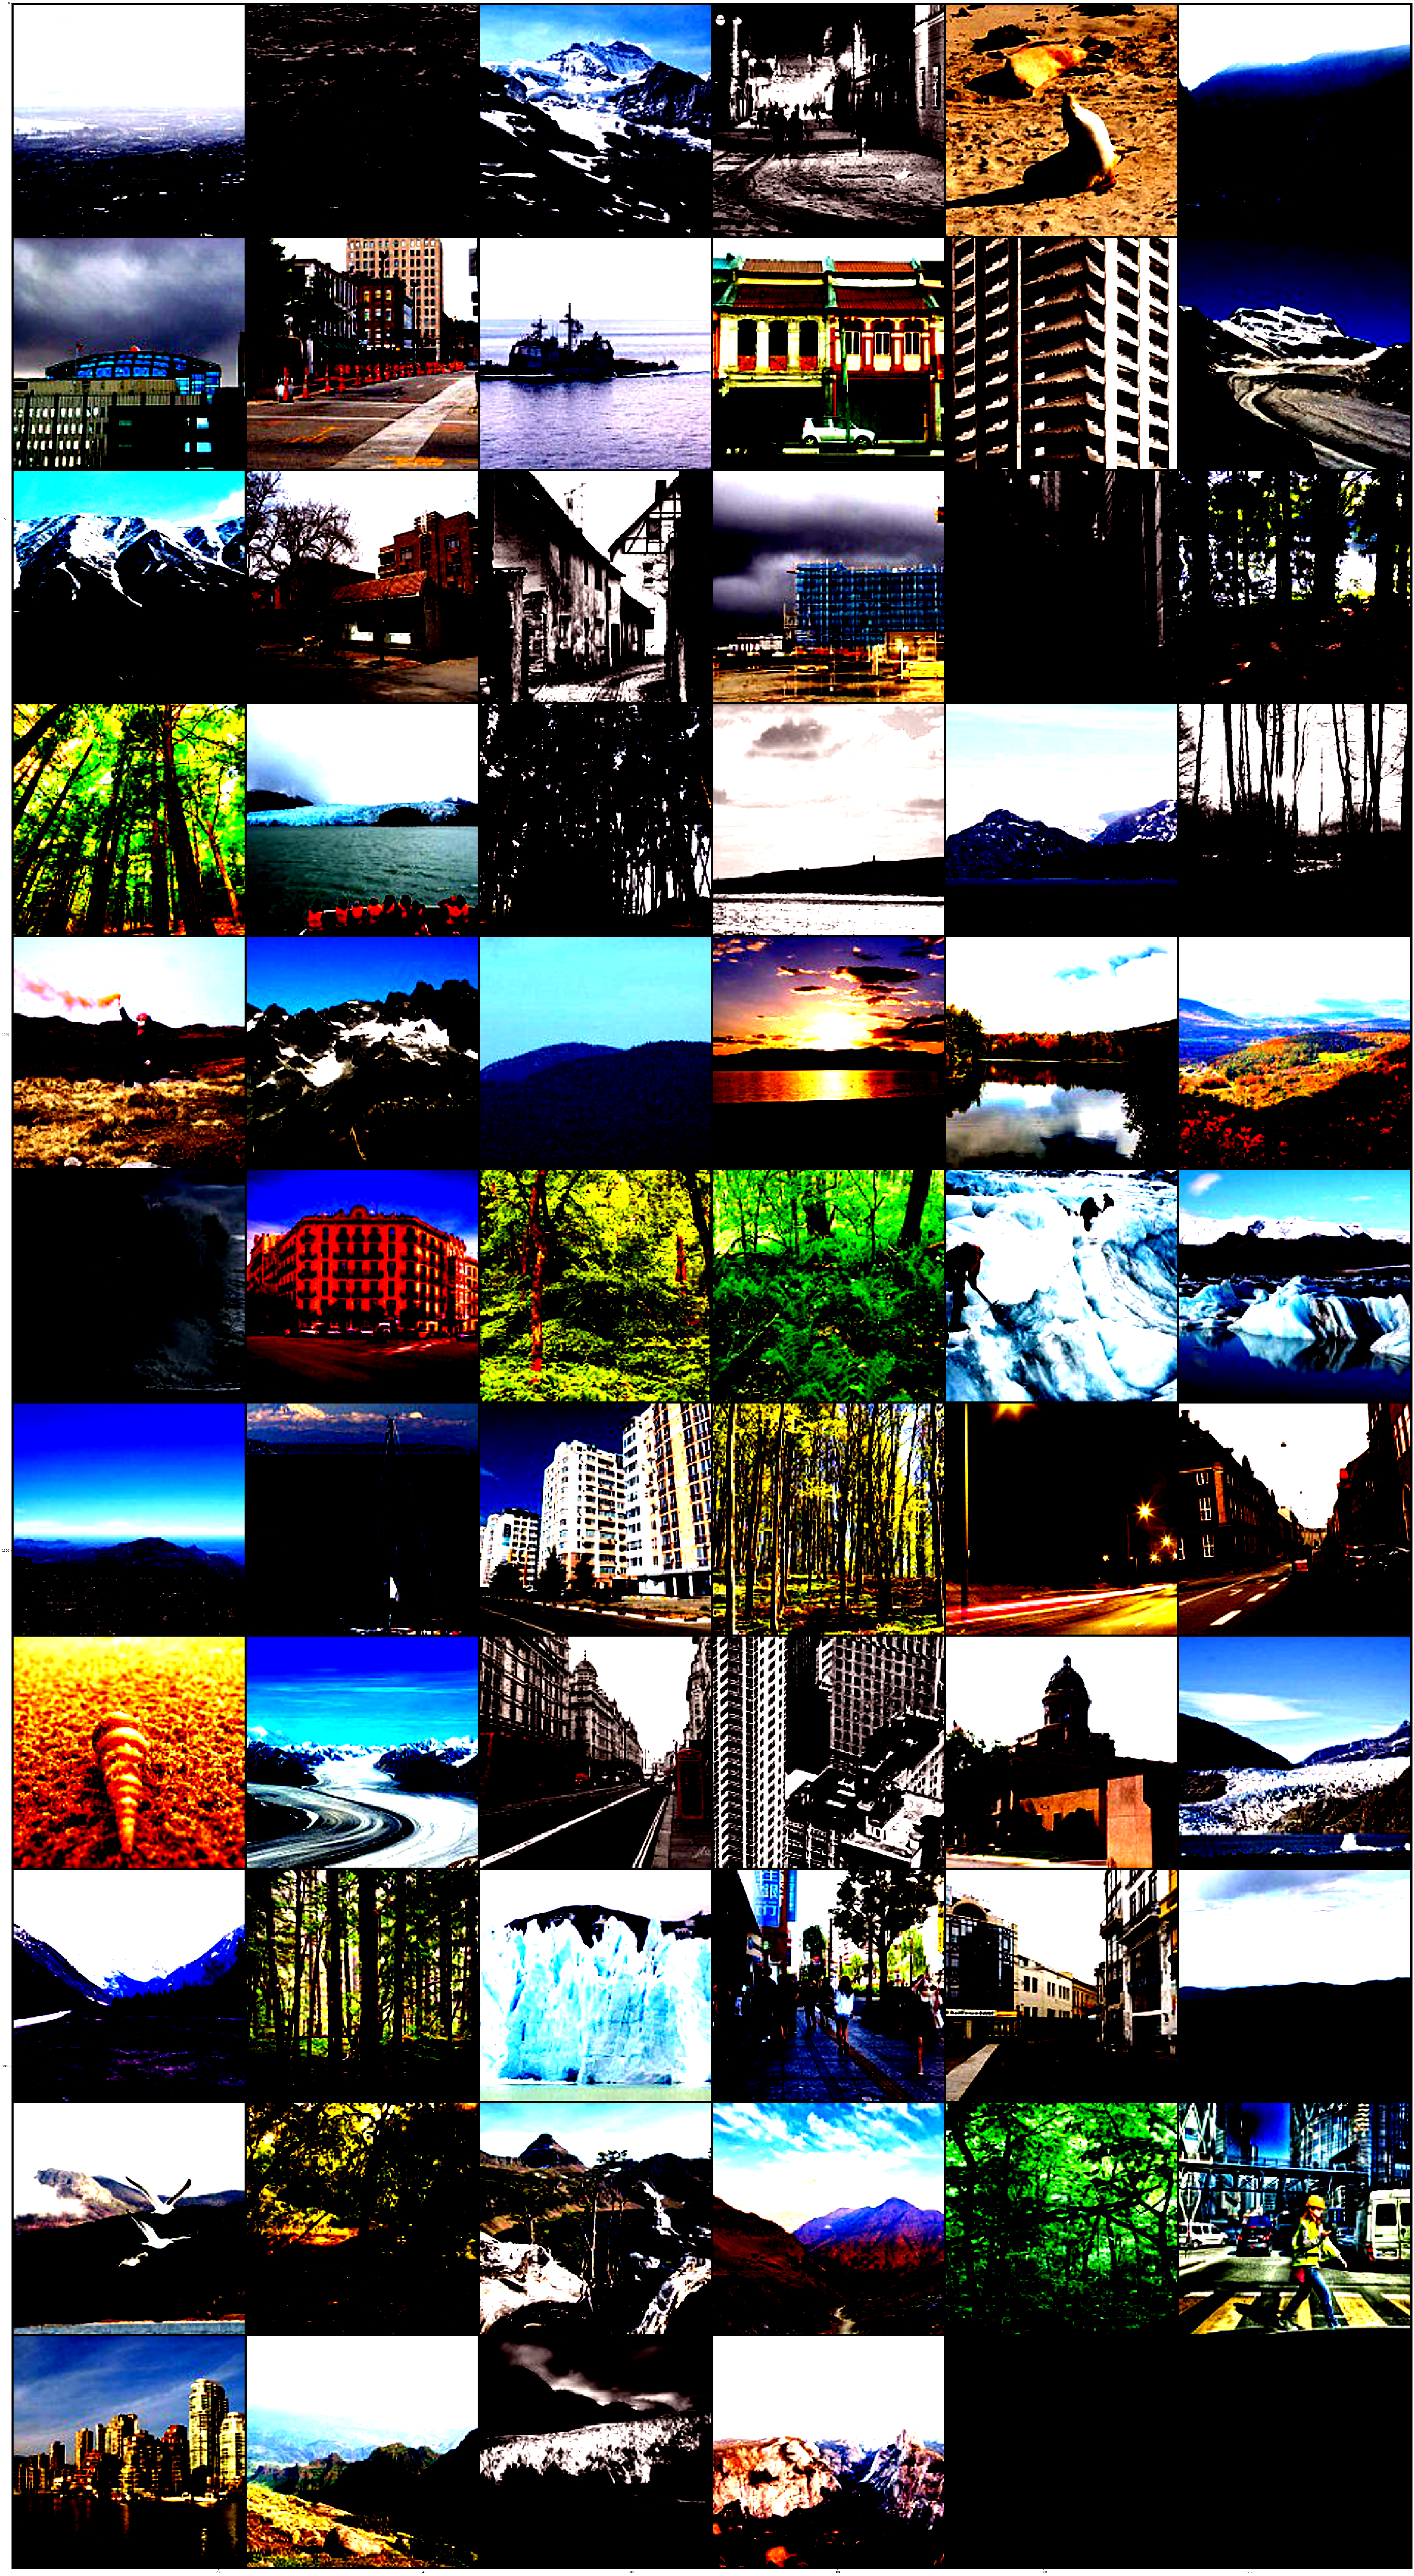

In [ ]:
show_img(test_data)

## **Create Models**
โดยที่ตัวแรกจะเป็น Resnet50 Architecture ซึ่งได้ผลลัพธ์ที่เป็นน่าพอใจ

In [ ]:
class construct(nn.Module):
    def __init__(self,input_channel,intermediate_channel,identity_downsample=None,stride = 1):
      super(construct,self).__init__()
      self.expansion = 4
      self.conv1 = nn.Conv2d(input_channel,intermediate_channel,kernel_size=1,stride=1,padding=0)
      self.batchnorm1 = nn.BatchNorm2d(intermediate_channel)
      self.conv2 = nn.Conv2d(intermediate_channel,intermediate_channel,kernel_size=3,stride=stride,padding=1)
      self.batchnorm2 = nn.BatchNorm2d(intermediate_channel)
      self.conv3 = nn.Conv2d(intermediate_channel,intermediate_channel*self.expansion,kernel_size=1,stride=1,padding=0)
      self.batchnorm3 = nn.BatchNorm2d(intermediate_channel*self.expansion)
      self.maxpooling = nn.MaxPool2d(kernel_size=4)
      self.relu = nn.ReLU()
      self.identity_sample = identity_downsample
      self.stride = stride

    def forward(self,x):
      identity = x.clone()
      
      x = self.conv1(x)
      
      x = self.batchnorm1(x)
      
      x = self.relu(x)
      
      x = self.conv2(x)
      
      x = self.batchnorm2(x)
     
      x = self.relu(x)
      
      x = self.conv3(x)
      
      x = self.batchnorm3(x)
      
      if(self.identity_sample is not None):
        identity = self.identity_sample(identity)
      x += identity
      x = self.relu(x)

      return x
      
class Resnet(nn.Module):
    def __init__(self,construct,layers,img_channel,numclass):
      super(Resnet,self).__init__()
      self.in_channel = 64
      self.conv1 = nn.Conv2d(img_channel,64,kernel_size=7,stride=2,padding=3)
      self.batchnorm1 = nn.BatchNorm2d(64)
      self.relu = nn.ReLU()
      self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
      self.Layer1 = self.__make__Layers(construct,layers[0],intermediate_channel=64,stride=1)
      self.Layer2 = self.__make__Layers(construct,layers[1],intermediate_channel=128,stride=2)
      self.Layer3 = self.__make__Layers(construct,layers[2],intermediate_channel=256,stride=2)
      self.Layer4 = self.__make__Layers(construct,layers[3],intermediate_channel=512,stride=2)
      self.fc = nn.Linear(512*4,numclass)
      self.avgpool = nn.AdaptiveAvgPool2d((1,1))
      
    def __make__Layers(self,construct,num_residual,intermediate_channel,stride):
      identity_downsample = None
      layers = []
      if stride != 1 or self.in_channel != intermediate_channel*4:
        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channel,intermediate_channel*4,kernel_size=1,stride=stride,bias=False),nn.BatchNorm2d(intermediate_channel*4),)
        layers.append(construct(self.in_channel,intermediate_channel,identity_downsample,stride))
        self.in_channel = intermediate_channel*4
        for i in range(num_residual - 1):
          layers.append(construct(self.in_channel,intermediate_channel))
        return nn.Sequential(*layers)

    def forward(self,x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.Layer1(x)
        x = self.Layer2(x)
        x = self.Layer3(x)
        x = self.Layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0],-1)
        x = self.fc(x)
        return x


def Resnet50(image_channel=3,num_class=6):
  return Resnet(construct,[3,4,6,3],image_channel,num_class)



In [ ]:
class CNN(nn.Module):
  def __init__(self,input_channel=3,num_class=6):
    super(CNN,self).__init__()
    self.conv1 = nn.Conv2d(input_channel,200,kernel_size=(3,3))
    self.conv1_1 = nn.Conv2d(200,150,kernel_size=(3,3))
    self.conv2 = nn.Conv2d(150,120,kernel_size=(3,3))
    self.conv2_1 = nn.Conv2d(120,80,kernel_size=(3,3))
    self.conv2_2 = nn.Conv2d(80,50,kernel_size=(3,3))
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)
    self.maxs = nn.MaxPool2d((4,4))
    self.Flat = nn.Flatten()
    self.drop = nn.Dropout(0.5)
    self.FC1 = nn.Linear(7200,120)
    self.FC2 = nn.Linear(120,100)
    self.FC3 = nn.Linear(100,50)
    self.FC4 = nn.Linear(50,6)

  def forward(self,x):
      x = self.conv1(x)
      x = self.relu(x)
      x = self.conv1_1(x)
      x = self.relu(x)
      x = self.maxs(x)
      x = self.conv2(x)
      x = self.relu(x)
      x = self.conv2_1(x)
      x = self.relu(x)
      x = self.conv2_2(x)
      x = self.relu(x)
      x = self.maxs(x)
      x = self.Flat(x)
      x = self.FC1(x)
      x = self.relu(x)
      x = self.FC2(x)
      x = self.relu(x)
      x = self.FC3(x)
      x = self.relu(x)
      x = self.drop(x)
      x = self.FC4(x)
      x = self.softmax(x)
      return x
     




In [ ]:
class VGG16(nn.Module):
    def __init__(self,input_channel=3,num_class=6):
      super(VGG16,self).__init__()
      self.conv1 = nn.Conv2d(input_channel,96,kernel_size=(11,11),stride=4,padding=2)
      self.conv1_1 = nn.Conv2d(64,64,kernel_size=(3,3),padding='same')
      self.conv2 = nn.Conv2d(96,256,kernel_size=(5,5),stride=1,padding=2)
      self.conv2_1 = nn.Conv2d(128,128,kernel_size=(3,3),padding='same')
      self.conv3 = nn.Conv2d(256,384,kernel_size=(3,3),padding='same')
      self.conv3_1 = nn.Conv2d(384,384,kernel_size=(3,3),padding='same')
      self.conv4 = nn.Conv2d(384,256,kernel_size=(3,3),padding='same')
      self.conv4_1 = nn.Conv2d(512,512,kernel_size=(3,3),padding='same')
      self.conv5 = nn.Conv2d(512,512,kernel_size=(3,3),padding='same')
      self.relu = nn.ReLU()
      self.FC1 = nn.Linear(9216,4096)
      self.FC2 = nn.Linear(4096,4096)
      self.FC3 = nn.Linear(4096,6)
      self.drop = nn.Dropout(0.5)
      self.Flatten = nn.Flatten()
      self.maxpooling1 = nn.MaxPool2d(kernel_size=(3,3),stride=(2,2))
      self.maxpooling2 = nn.MaxPool2d(kernel_size=3)
      self.softmax = nn.Softmax(dim=1)

    def forward(self,x):
      x = self.conv1(x)
      x = self.relu(x)
      #x = self.conv1_1(x)
      #x = self.relu(x)
      x = self.maxpooling1(x)
      x = self.conv2(x)
      x = self.relu(x)
      #x = self.conv2_1(x)
      #x = self.relu(x)
      x = self.maxpooling1(x)
      x = self.conv3(x)
      x = self.relu(x)
      x = self.conv3_1(x)
      x = self.relu(x)
      x = self.conv3_1(x)
      x = self.relu(x)
      #x = self.maxpooling1(x)
      x = self.conv4(x)
      x = self.relu(x)
      #x = self.conv4_1(x)
      #x = self.relu(x)
      #x = self.conv4_1(x)
      #x = self.relu(x)
      x = self.maxpooling1(x)
      #x = self.conv5(x)
      #x = self.relu(x)
     # x = self.conv4_1(x)
      #x = self.relu(x)
      #x = self.conv4_1(x)
      #x = self.relu(x)
      #x = self.maxpooling1(x)
      x = self.Flatten(x)
      x = self.FC1(x)
      x = self.relu(x)
      x = self.drop(x)
      x = self.FC2(x)
      x = self.relu(x)
      x = self.drop(x)
      x = self.FC3(x)
      x = self.softmax(x)
      return x


In [ ]:
def Resnet152(image_channel=3,num_class=6):
  return Resnet(construct,[3,8,36,3],image_channel,num_class)

In [ ]:
model_scratch = Resnet50().to('cuda:0')
#model_scratch = CNN().to('cuda:0')
#model_cnn = CNN()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_scratch.parameters(),lr=0.00008)

In [ ]:
!pip install torchsummary

from torchsummary import summary
summary(model_scratch,input_size=(3,224,224))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,640
      BatchNorm2d-12          [-1, 256, 56, 56]             512
    

In [ ]:
num_epoch = 45

for epoch in range(num_epoch):
  train_loss, value_loss = 0.0,0.0
  correct, value_correct = 0,0

  model_scratch.train()
  for i,(x,y) in enumerate(DataLoad_training):
    x,y = x.to('cuda:0'),y.to('cuda:0')

    optimizer.zero_grad()
    y_predict = model_scratch(x)
    loss = loss_fn(y_predict,y)
    loss.backward()

    optimizer.step()
    train_loss += loss.item()
    predict = y_predict.argmax(dim=1,keepdim=True)
    correct += predict.eq(y.view_as(predict)).sum().item()

  print(f'Epoch {epoch} : Train loss: {train_loss/len(DataLoad_training):8.5f} , Train acc: {100*correct/len(DataLoad_training.dataset):6.2f}%')

  model_scratch.eval()
  value_correct =0
  with torch.no_grad():
      for x,y in DataLoad_test:
        x,y = x.to('cuda:0'),y.to('cuda:0')
        y_predict = model_scratch(x)

        loss = loss_fn(y_predict,y)
        value_loss += loss.item()

        predict = y_predict.argmax(dim=1,keepdim=True)
        value_correct += predict.eq(y.view_as(predict)).sum().item()

      print(f'\t Valid loss: {value_loss/len(DataLoad_test):8.5f} , Valid acc: {100*value_correct/len(DataLoad_test.dataset):6.2f}%')



## **ทำการ test ข้อมูล**

In [ ]:
##model_scratch.eval()
test = 0.0
for x,y in DataLoad_test:
  x,y = x.to('cuda:0'), y.to('cuda:0')
  y_pre = model_scratch(x)
  predict = y_pre.argmax(dim=1,keepdim=True)
  test += predict.eq(y.view_as(predict)).sum().item()

print(f'Test acc = {100*test/len(DataLoad_test.dataset):6.2f}%')
  